# Calibration

Calibration in AI, especially in the context of machine learning, refers to how well the predicted probabilities of a model align with the actual outcomes. It is particularly important for models that provide probabilistic predictions, such as classification models that output probabilities (like 70% chance of class A, 30% chance of class B).

Here’s a breakdown of what calibration means and why it matters:

### 1. **Understanding Predictions**
   In many machine learning models, instead of just giving a hard decision ("yes" or "no"), the model outputs a probability score. For example, a model predicting whether an email is spam might say there’s an 80% chance it's spam and a 20% chance it’s not.

### 2. **Well-Calibrated Models**
   A model is said to be "well-calibrated" if the predicted probabilities match the actual outcomes over time.
   
   **Example**:
   - If your model predicts that 100 emails each have an 80% chance of being spam, we would expect that about 80 of those emails would actually be spam.
   
   In a perfectly calibrated model, whenever it gives a probability of 80%, we would indeed see the predicted event happening 80% of the time.

### 3. **Why Calibration is Important**
   - **Decision-Making**: When a model is well-calibrated, you can trust its probability estimates. This is especially useful in fields like medicine, finance, and autonomous systems where knowing how uncertain or confident the model is about its prediction is crucial.
   - **Risk Assessment**: In scenarios where you need to evaluate risk (e.g., predicting whether a patient has a disease), understanding the model’s confidence helps make better decisions.

### 4. **Under-Confident vs. Over-Confident Models**
   - **Over-confident model**: If a model predicts 90% confidence in an outcome, but the actual outcome happens only 50% of the time, it’s over-confident.
   - **Under-confident model**: If a model predicts a 50% chance for an outcome, but the outcome actually occurs 90% of the time, it’s under-confident.
   
   Over-confident models can be dangerous because they might give users a false sense of certainty. Under-confident models, on the other hand, might lead users to underestimate the likelihood of an event that is actually quite likely.

### 5. **How to Measure Calibration**
   - **Reliability Diagram**: This is a common way to visualize calibration. It plots the predicted probability on the x-axis and the actual observed frequency on the y-axis. A perfectly calibrated model would follow a diagonal line from (0, 0) to (1, 1).
   - **Expected Calibration Error (ECE)**: This is a numerical metric that summarizes how far the model’s predicted probabilities deviate from actual outcomes. The lower the ECE, the better the calibration.

### 6. **Improving Calibration**
   Some models, like decision trees and random forests, tend to be poorly calibrated by default. You can use techniques like **Platt scaling** or **isotonic regression** to improve calibration after training.

   - **Platt scaling**: Fits a logistic regression model on the model’s scores to adjust the probabilities.
   - **Isotonic regression**: A non-parametric method that fits a piecewise constant function to adjust the probabilities.

### 7. **When Calibration Matters Most**
   - **High-stakes predictions**: In fields like healthcare or autonomous driving, where decisions based on model predictions can have serious consequences, calibrated probabilities help professionals make informed choices.
   - **Uncertainty estimation**: In AI systems where we care not only about the predicted class but also about how sure the model is, calibration becomes essential.

### Example:
   Let’s say you build a model to predict whether a patient has a disease. If your model is 90% confident that a patient has the disease, and the model is well-calibrated, you should be able to trust that about 9 out of 10 people with a 90% score actually have the disease. If your model is overconfident, it might say it’s 90% sure when it should be less confident, leading to incorrect treatments.

In summary, calibration ensures that the probabilities output by your model match reality as closely as possible, allowing users to trust the model’s predictions more effectively.

# Probability calibration of classifiers

When performing classification you often want to predict not only the class label, but also the associated probability. This probability gives you some kind of confidence on the prediction. However, not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. Thus, a separate calibration of predicted probabilities is often desirable as a postprocessing. This example illustrates two different methods for this calibration and evaluates the quality of the returned probabilities using Brier’s score (see https://en.wikipedia.org/wiki/Brier_score).

Compared are the estimated probability using a Gaussian naive Bayes classifier without calibration, with a sigmoid calibration, and with a non-parametric isotonic calibration. One can observe that only the non-parametric model is able to provide a probability calibration that returns probabilities close to the expected 0.5 for most of the samples belonging to the middle cluster with heterogeneous labels. This results in a significantly improved Brier score.

In [1]:
# synthetic dataset
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

y[: n_samples // 2] = 0
y[n_samples // 2 :] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.9, random_state=42
)

In [2]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.naive_bayes import GaussianNB

# With no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# With isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# With sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


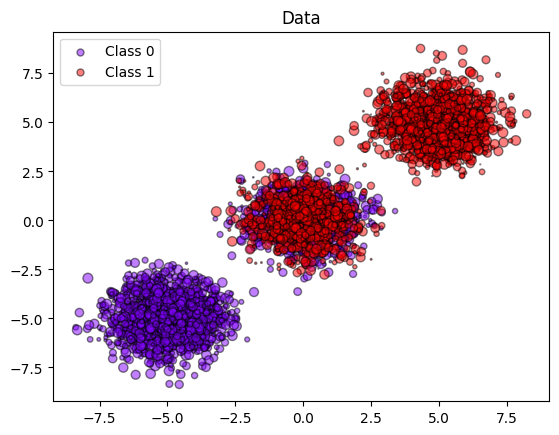

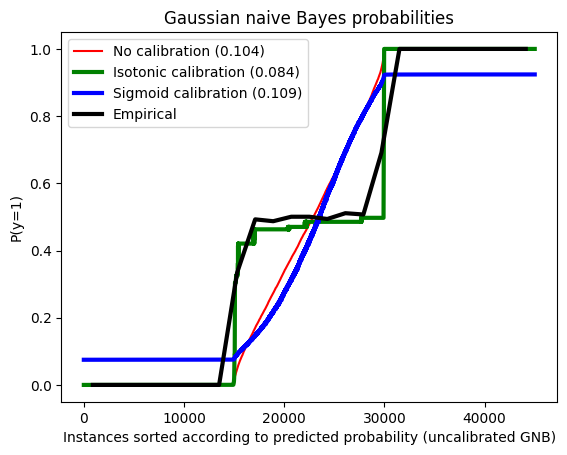

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
plt.legend(loc="best")
plt.title("Data")

plt.figure()

order = np.lexsort((prob_pos_clf,))
plt.plot(prob_pos_clf[order], "r", label="No calibration (%1.3f)" % clf_score)
plt.plot(
    prob_pos_isotonic[order],
    "g",
    linewidth=3,
    label="Isotonic calibration (%1.3f)" % clf_isotonic_score,
)
plt.plot(
    prob_pos_sigmoid[order],
    "b",
    linewidth=3,
    label="Sigmoid calibration (%1.3f)" % clf_sigmoid_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    "k",
    linewidth=3,
    label=r"Empirical",
)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability (uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

# Comparison of Calibration of Classifiers

Well calibrated classifiers are probabilistic classifiers for which the output of predict_proba can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that for the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

In this example we will compare the calibration of four different models: Logistic regression, Gaussian Naive Bayes, Random Forest Classifier and Linear SVM.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

**Calibration curves**

Below, we train each of the four models with the small training dataset, then plot calibration curves (also known as reliability diagrams) using predicted probabilities of the test dataset. Calibration curves are created by binning predicted probabilities, then plotting the mean predicted probability in each bin against the observed frequency (‘fraction of positives’). Below the calibration curve, we plot a histogram showing the distribution of the predicted probabilities or more specifically, the number of samples in each predicted probability bin.

In [5]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [6]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# Define the classifiers to be compared in the study.
#
# Note that we use a variant of the logistic regression model that can
# automatically tune its regularization parameter.
#
# For a fair comparison, we should run a hyper-parameter search for all the
# classifiers but we don't do it here for the sake of keeping the example code
# concise and fast to execute.
lr = LogisticRegressionCV(
    Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
)
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


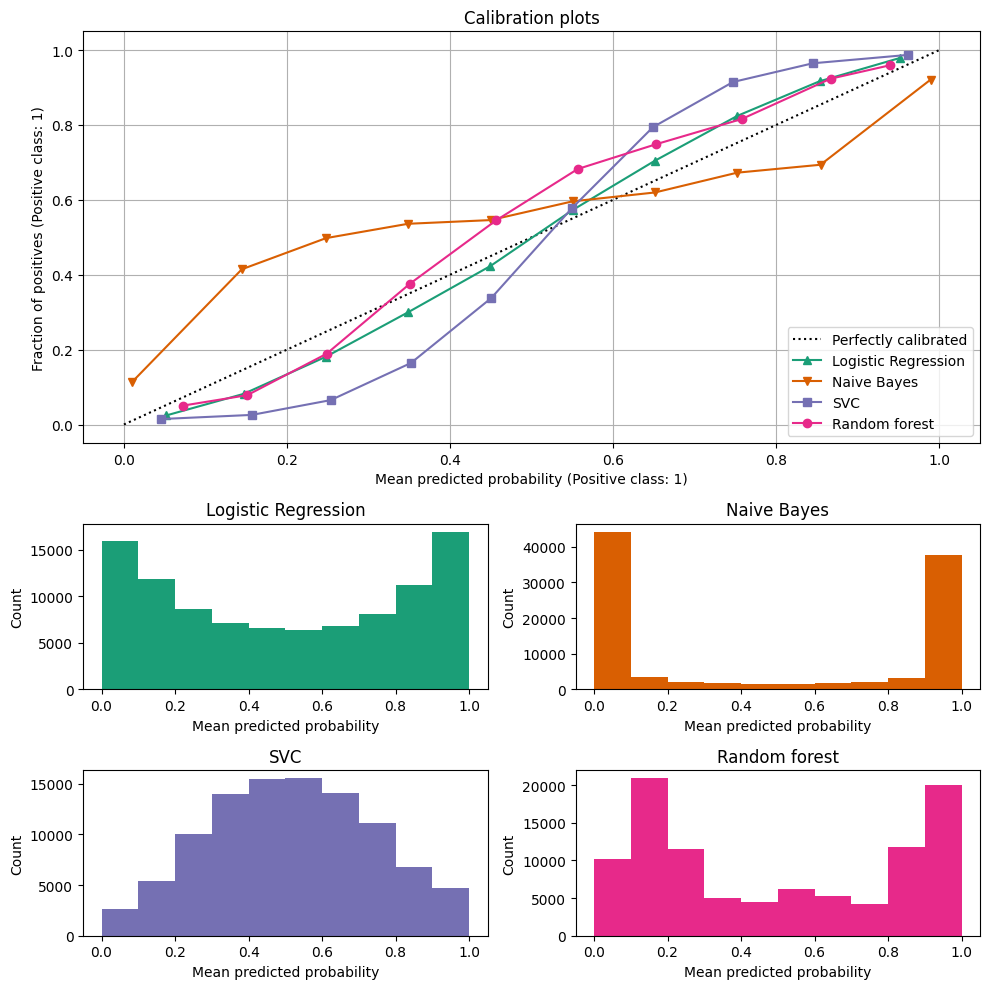

In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

**Analysis of the results**

LogisticRegressionCV returns reasonably well calibrated predictions despite the small training set size: its reliability curve is the closest to the diagonal among the four models.

Logistic regression is trained by minimizing the log-loss which is a strictly proper scoring rule: in the limit of infinite training data, strictly proper scoring rules are minimized by the model that predicts the true conditional probabilities. That (hypothetical) model would therefore be perfectly calibrated. However, using a proper scoring rule as training objective is not sufficient to guarantee a well-calibrated model by itself: even with a very large training set, logistic regression could still be poorly calibrated, if it was too strongly regularized or if the choice and preprocessing of input features made this model mis-specified (e.g. if the true decision boundary of the dataset is a highly non-linear function of the input features).

In this example the training set was intentionally kept very small. In this setting, optimizing the log-loss can still lead to poorly calibrated models because of overfitting. To mitigate this, the LogisticRegressionCV class was configured to tune the C regularization parameter to also minimize the log-loss via inner cross-validation so as to find the best compromise for this model in the small training set setting.

Because of the finite training set size and the lack of guarantee for well-specification, we observe that the calibration curve of the logistic regression model is close but not perfectly on the diagonal. The shape of the calibration curve of this model can be interpreted as slightly under-confident: the predicted probabilities are a bit too close to 0.5 compared to the true fraction of positive samples.

The other methods all output less well calibrated probabilities:

- GaussianNB tends to push probabilities to 0 or 1 (see histogram) on this particular dataset (over-confidence). This is mainly because the naive Bayes equation only provides correct estimate of probabilities when the assumption that features are conditionally independent holds [2]. However, features can be correlated and this is the case with this dataset, which contains 2 features generated as random linear combinations of the informative features. These correlated features are effectively being ‘counted twice’, resulting in pushing the predicted probabilities towards 0 and 1 [3]. Note, however, that changing the seed used to generate the dataset can lead to widely varying results for the naive Bayes estimator.
- LinearSVC is not a natural probabilistic classifier. In order to interpret its prediction as such, we naively scaled the output of the decision_function into [0, 1] by applying min-max scaling in the NaivelyCalibratedLinearSVC wrapper class defined above. This estimator shows a typical sigmoid-shaped calibration curve on this data: predictions larger than 0.5 correspond to samples with an even larger effective positive class fraction (above the diagonal), while predictions below 0.5 corresponds to even lower positive class fractions (below the diagonal). This under-confident predictions are typical for maximum-margin methods [1].
- RandomForestClassifier’s prediction histogram shows peaks at approx. 0.2 and 0.9 probability, while probabilities close to 0 or 1 are very rare. An explanation for this is given by [1]: “Methods such as bagging and random forests that average predictions from a base set of models can have difficulty making predictions near 0 and 1 because variance in the underlying base models will bias predictions that should be near zero or one away from these values. Because predictions are restricted to the interval [0, 1], errors caused by variance tend to be one-sided near zero and one. For example, if a model should predict p = 0 for a case, the only way bagging can achieve this is if all bagged trees predict zero. If we add noise to the trees that bagging is averaging over, this noise will cause some trees to predict values larger than 0 for this case, thus moving the average prediction of the bagged ensemble away from 0. We observe this effect most strongly with random forests because the base-level trees trained with random forests have relatively high variance due to feature subsetting.” This effect can make random forests under-confident. Despite this possible bias, note that the trees themselves are fit by minimizing either the Gini or Entropy criterion, both of which lead to splits that minimize proper scoring rules: the Brier score or the log-loss respectively. See the user guide for more details. This can explain why this model shows a good enough calibration curve on this particular example dataset. Indeed the Random Forest model is not significantly more under-confident than the Logistic Regression model.
Feel free to re-run this example with different random seeds and other dataset generation parameters to see how different the calibration plots can look. In general, Logistic Regression and Random Forest will tend to be the best calibrated classifiers, while SVC will often display the typical under-confident miscalibration. The naive Bayes model is also often poorly calibrated but the general shape of its calibration curve can vary widely depending on the dataset.

Finally, note that for some dataset seeds, all models are poorly calibrated, even when tuning the regularization parameter as above. This is bound to happen when the training size is too small or when the model is severely misspecified.